# Basic working examples of parameter estimation

In [1]:
using DifferentialEquations
using Thyrosim
using Plots
using DiffEqCallbacks
using Optim
using DiffEqParamEstim

┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.2/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.2/Thyrosim/Oo7R6.ji for Thyrosim [7ef34fca-2b35-11e9-1aeb-a527bedb189e]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.2/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.2/DiffEqParamEstim/nWq0E.ji for DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1240
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = lstirling_asym(::BigFloat) at mis

## Import data and initial conditions

In [52]:
train, test, toy = schneider_data();

In [12]:
# useful parameters
train[!, Symbol("Days.to.euthyroid")]
train[!, Symbol("Wt.kg")]
train[!, Symbol("Sex")]
train[!, Symbol("Ht.m")]
train[!, Symbol("TSH.preop")]
train[!, Symbol("LT4.euthyroid.dose")]
train[!, Symbol("Dose.changes")]

400-element CSV.Column{Int64,Int64}:
 0
 3
 2
 2
 2
 2
 2
 0
 1
 2
 1
 0
 3
 ⋮
 2
 0
 2
 1
 0
 0
 1
 0
 1
 2
 2
 1

## Solve 1 schneider patient

In [60]:
# each row is a patient's tspan
total_days = train[!, Symbol("Days.to.euthyroid")]
tspans = [(0.0, 24.0total_days[i]) for i in 1:length(total_days)]

400-element Array{Tuple{Float64,Float64},1}:
 (0.0, 1320.0) 
 (0.0, 2376.0) 
 (0.0, 5208.0) 
 (0.0, 4296.0) 
 (0.0, 3864.0) 
 (0.0, 3744.0) 
 (0.0, 4560.0) 
 (0.0, 1032.0) 
 (0.0, 2424.0) 
 (0.0, 3720.0) 
 (0.0, 2136.0) 
 (0.0, 1656.0) 
 (0.0, 5376.0) 
 ⋮             
 (0.0, 6744.0) 
 (0.0, 2208.0) 
 (0.0, 3792.0) 
 (0.0, 1896.0) 
 (0.0, 336.0)  
 (0.0, 1416.0) 
 (0.0, 2208.0) 
 (0.0, 1080.0) 
 (0.0, 10224.0)
 (0.0, 5904.0) 
 (0.0, 2424.0) 
 (0.0, 4008.0) 

In [61]:
# 400 mcg of oral T4
function affect!(integrator)
    T4_dose = 400.0 / 777.0  
    T3_dose = 0.0
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[10] += T4_dose
    integrator.u[12] += T3_dose
end

cbk = PeriodicCallback(affect!, 24.0);

# ODE problem
ic, p = initialize([0.0; 0.88; 0.0; 0.88]) # schneider patients are completely thyroidectomized
train_patient_1 = ODEProblem(thyrosim,ic,tspans[1],p,callback=cbk)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 1320.0)
u0: [0.322114215761171, 0.201296960359917, 0.63896741190756, 0.00663104034826483, 0.0112595761822961, 0.0652960640300348, 1.7882958476437, 7.05727560072869, 7.05714474742141, 0.0, 0.0, 0.0, 0.0, 3.34289716182018, 3.69277248068433, 3.87942133769244, 3.90061903207543, 3.77875734283571, 3.55364471589659]

In [71]:
sol = solve(train_patient_1)
sol[end-24:end]

retcode: Success
Interpolation: Automatic order switching interpolation
t: 25-element Array{Float64,1}:
 1310.2263011265936
 1310.564265233478 
 1310.9213336130208
 1311.3038673830665
 1311.7236690760772
 1312.2113260167732
 1312.8077539769065
 1313.3345624217973
 1313.8502968156527
 1314.3488179592289
 1314.830867407782 
 1315.2961987254876
 1315.7451044245627
 1316.1781678297414
 1316.5961926455232
 1317.0001173677451
 1317.3909561429982
 1317.7697570125836
 1318.137574658376 
 1318.4954539673524
 1318.8444217148797
 1319.1854843936421
 1319.5196308744833
 1319.847839162069 
 1320.0            
u: 25-element Array{Array{Float64,1},1}:
 [0.8658912500426779, 0.8318210486040264, 2.732445968892521, 0.0068537396811719645, 0.014673298310234046, 0.08269637539819899, 0.01928961708846982, 13.334116114842205, 13.336924641670043, 4.428797325087572e-9, 1.6577734634258628e-6, 0.0, 0.0, 0.016904479488983885, 0.014651683954882585, 0.012847363538443754, 0.01169800010470996, 0.011280968642982482, 0.0

## Build loss function 

Simulate patients according to the number of days the patient achieved euthyrodism using the given dose, then calculate if their TSH levels are within [0.45, 4.5] mIU/ml.

In [ ]:
# NEED an affect! function that will accept T4_dose as input argument
function affect!(integrator)
    T4_dose = 400.0 / 777.0  
    T3_dose = 0.0
    
    integrator.u[10] += T4_dose
    integrator.u[12] += T3_dose
end

cbk = PeriodicCallback(affect!, 24.0);

In [75]:
function simulate_all_schneider(train_data)
   # simulate all patients, tally and add up those who fall beyond the range
    dial = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true
    tot_loss = 0
    for i in 1:size(train, 1)
        height = train_data[i, Symbol("Ht.m")]
        weight = train_data[i, Symbol("Wt.kg")]
        sex    = train_data[i, Symbol("Sex")]
        ic, p  = initialize(dial, scale_Vp, height, weight, sex)
        ic[7]  = train_data[i, Symbol("TSH.preop")]
        tspan  = (0.0, 24.0train[i, Symbol("Days.to.euthyroid")]) #(0, total hours)
        
        # calculate error
        cbk  = ???
        prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
        sol  = solve(prob, save_idxs=[7]) # save only TSH values
        tot_loss += schneider_train_loss(sol)
    end 
end

LoadError: syntax: invalid identifier name "?"

In [74]:
function schneider_loss(sol)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        # calculate error
        TSH_last_day = sol[# get only last 24 hours!] 
        
    end
    tot_loss
end

LoadError: syntax: unexpected "end"

## Write optimization routines 

Read about closures [here](http://julianlsolvers.github.io/Optim.jl/latest/#user/tipsandtricks/#_top). 

In [4]:
fitting_index = [30, 31]
dial = [1.0; 0.88; 1.0; 0.88]
function closure(p, fitting_index, dial)
    reset_p!(p, fitting_index, dial)
    return cost_function(p)
end

# optimize p on fitting index using the default algorithm BFGS()
result = optimize(p -> closure(p, fitting_index, dial), p, BFGS())

# inspect result
result.minimizer[fitting_index]

2-element Array{Float64,1}:
 1357.7527328493427
  632.0295259741087

# Now optimize over 3 sets of T4 oral dose

In [5]:
# calculate TSH error for 400, 450, and 600 datasets
cost_function_400 = build_loss_objective(prob,Tsit5(),L2Loss(my_time, my400_data[:, 3]),
                                     maxiters=10000,verbose=false, save_idxs=[7])

cost_function_450 = build_loss_objective(prob,Tsit5(),L2Loss(my_time, my450_data[:, 3]),
                                     maxiters=10000,verbose=false, save_idxs=[7])

cost_function_600 = build_loss_objective(prob,Tsit5(),L2Loss(my_time, my600_data[:, 3]),
                                     maxiters=10000,verbose=false, save_idxs=[7])

(::DiffEqObjective{getfield(DiffEqParamEstim, Symbol("##43#48")){Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:maxiters, :verbose, :save_idxs),Tuple{Int64,Bool,Array{Int64,1}}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},ODEFunction{true,typeof(original_thyrosim),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Symbol,ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing},Tuple{Symbol},NamedTuple{(:callback,),Tuple{ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing}}}},DiffEqBase.StandardODEProblem},Tsit5,L2Loss{Array{Float64,1},Array{Float64,2},Nothing,Nothing,Nothing},Nothing},getfield(DiffEqParamEstim, Symbol("##47#53")){getfield(D

In [6]:
fitting_index = [30, 31]
dial = [1.0; 0.88; 1.0; 0.88]
function closure(p, fitting_index, dial)
    reset_p!(p, fitting_index, dial)
    return cost_function_400(p) + cost_function_450(p) + cost_function_600(p)
end

closure (generic function with 1 method)

In [7]:
# optimize p on fitting index using the default algorithm BFGS()
result = optimize(p -> closure(p, fitting_index, dial), p, BFGS())

 * Status: success

 * Candidate solution
    Minimizer: [1.74e-03, 8.00e+00, 8.68e-01,  ...]
    Minimum:   1.160527e+01

 * Found with
    Algorithm:     BFGS
    Initial Point: [1.74e-03, 8.00e+00, 8.68e-01,  ...]

 * Convergence measures
    |x - x'|               = 2.40e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.75e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.51e-13 ≰ 0.0e+00
    |g(x)|                 = 2.55e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   8  (vs limit Inf)
    Iterations:    6
    f(x) calls:    29
    ∇f(x) calls:   29


In [8]:
# inspect result
result.minimizer[fitting_index]

2-element Array{Float64,1}:
 1379.5487112601793
  629.7774683215114

In [9]:
# some code for plotting
function plot_blakesley(sol, which="400")
    markersize = 2
    t_data, data400, data450, data600 = blakesley_data()
    if which == "400"
        data = data400
    elseif which == "450"
        data = data450
    else
        data = data600
    end
    
    t_data = t_data / 24.0

    ## Need to change to pick better y limits!
    p = sol.prob.p 
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / p[47], ylim=(0, 140), label="",
       ylabel="T4", title="Thyrosim simulation (Blakesley data)")
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, data[:, 1], label="", markersize=markersize)
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / p[47], ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, data[:, 2], label="", markersize=markersize)
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / p[48], ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, data[:, 3], label="", markersize=markersize)
    
    plot(p1, p2, p3, layout=(3, 1))
end

plot_blakesley (generic function with 2 methods)

In [10]:
# check if fitting is better by plotting
new_prob = ODEProblem(original_thyrosim,ic,tspan,result.minimizer,callback=cbk)
old_sol  = solve(prob)
new_sol  = solve(new_prob);

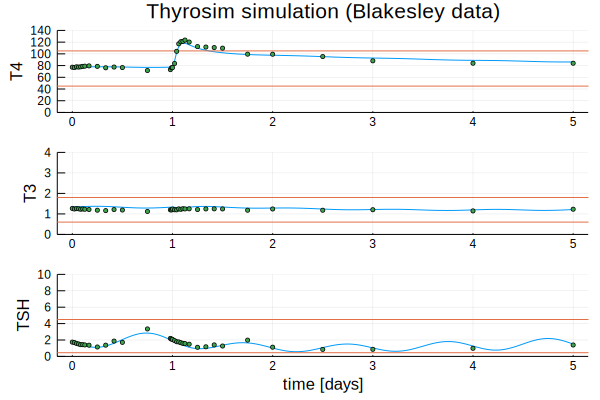

In [11]:
plot_blakesley(old_sol, "400")

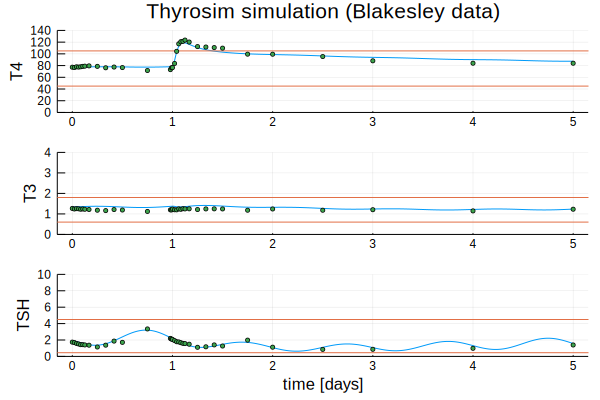

In [12]:
plot_blakesley(new_sol, "400")